In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# find the last day's date in data set
end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()


# as SQLAlchemy results are tuples, to extract date to string, just extract the first element
end_date = end_date[0]

# Calculate the date 1 year ago from the last data point in the database, use 366 days to include 2016-08-23
start_date = dt.datetime.strptime(end_date, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
query_result = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
weather_df = pd.DataFrame(query_result, columns=['date', 'precipitation'])


# Sort the dataframe by date
weather_df.set_index('date', inplace=True)
weather_df.sort_values(by='date', ascending=True)
weather_df = weather_df[pd.notnull(weather_df['precipitation'])]
weather_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


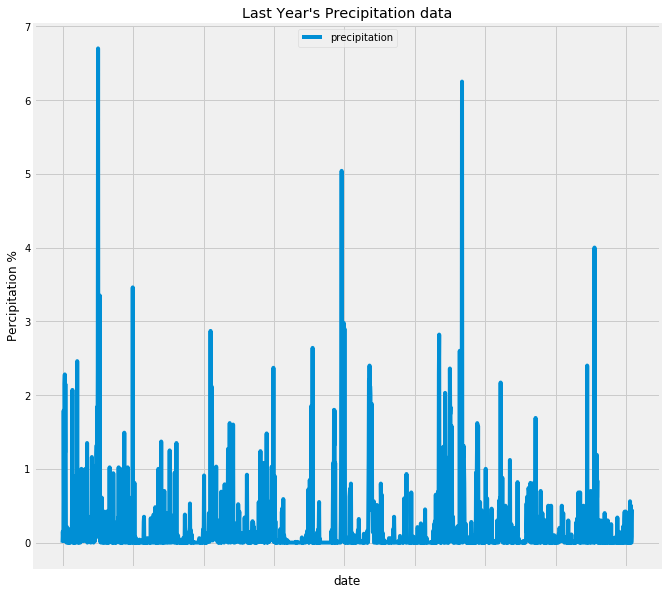

In [11]:
#Plot the results using the DataFrame plot method.
weather_df.plot(title='Last Year\'s Precipitation data', figsize=(10,10))
plt.ylabel('Percipitation %')
plt.legend(loc='upper center')
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
weather_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
top_station = active_stations[0][0]

top_station_temperatures = session.query(
        func.min(Measurement.tobs).label('Max Temp'), 
        func.max(Measurement.tobs).label('Min Temp'), 
        func.avg(Measurement.tobs).label('Avg Temp')).filter(Measurement.station == top_station).all()
top_station_temperatures

[(54.0, 85.0, 71.66378066378067)]

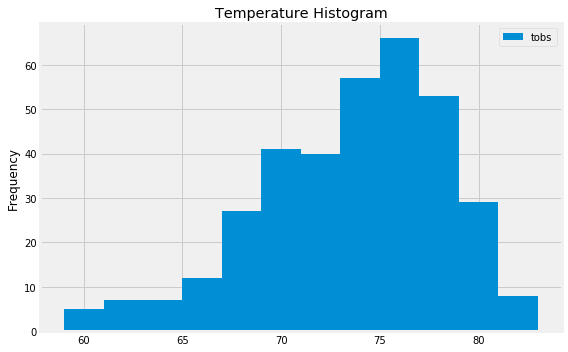

In [16]:
# Choose the station with the highest number of temperature observations.
highest_temp_station = session.query(Measurement.station,func.count(Measurement.tobs)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).first()

highest_temp_station

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs).filter(Measurement.date >= start_date).\
                filter(Measurement.station == highest_temp_station[0]).all()

temp_data_df = pd.DataFrame(temp_data, columns=['tobs'])
months = 12
temp_data_df.plot.hist(bins=months, title='Temperature Histogram', figsize=(8, 5))
plt.tight_layout()
plt.show()

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# User input for trip's start and end dates
start_date_input = input(f"Pick a starting date for your trip between 2010-01-01 and 2017-08-23 ")
year, month, day = map(int, start_date_input.split('-'))
trip_start_date = dt.date(year, month, day)

end_date_input = input(f"Pick an end date for your trip between 2010-01-01 and 2017-08-23 ")
year, month, day = map(int, end_date_input.split('-'))
trip_end_date = dt.date(year, month, day)

trip = calc_temps(trip_start_date, trip_end_date)
print(trip)

Pick a starting date for your trip between 2010-01-01 and 2017-08-23 2012-02-28
Pick an end date for your trip between 2010-01-01 and 2017-08-23 2012-03-05
[(62.0, 69.57142857142857, 74.0)]


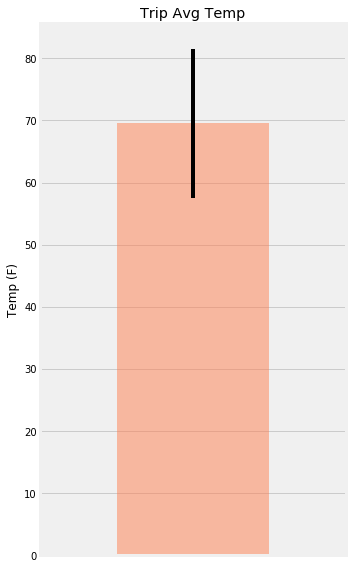

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])

p_to_p = trip_df['tmax'] - trip_df['tmin']

ax = trip_df.plot.bar(title='Trip Avg Temp', y='tavg', yerr=p_to_p, color='coral', alpha=0.5, figsize = (5, 8))
plt.ylabel('Temp (F)')
plt.xticks([]) # disable xticks
plt.tight_layout()
plt.gca().legend_.remove()
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def percipitation(start_date, end_date):
    
    sel = [
        Measurement.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        Measurement.prcp
    ]
    
    return session.query(*sel).filter(Measurement.station == Station.station).\
        filter(Measurement.date >= trip_start_date).\
        filter(Measurement.date <= trip_end_date).\
        group_by(Measurement.station).\
        order_by(Measurement.prcp.desc()).all()

print(percipitation('2016-01-01', '2016-01-15'))


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.4), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.05), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.03), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, None)]
